# Self-Driving Car Engineer Nanodegree
## Project: Advanced Finding Lane Lines on the Road
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read Calibration Images

In [3]:
cal_images = glob.glob("./camera_cal/calibration*.jpg")

## 1. Calibrate Camera

In [4]:
def find_points(images):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image space
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    for fname in images:
        # 1) read in  each image
        img = mpimg.imread(fname)
        # 2) convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # 3) find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
        # 4) if corners are found ,add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return imgpoints, objpoints

def cal_undistort(img, objpoints, imgpoints):
    img_size = img.shape[:2][::-1]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    return dst

### Example: Test on chess board images

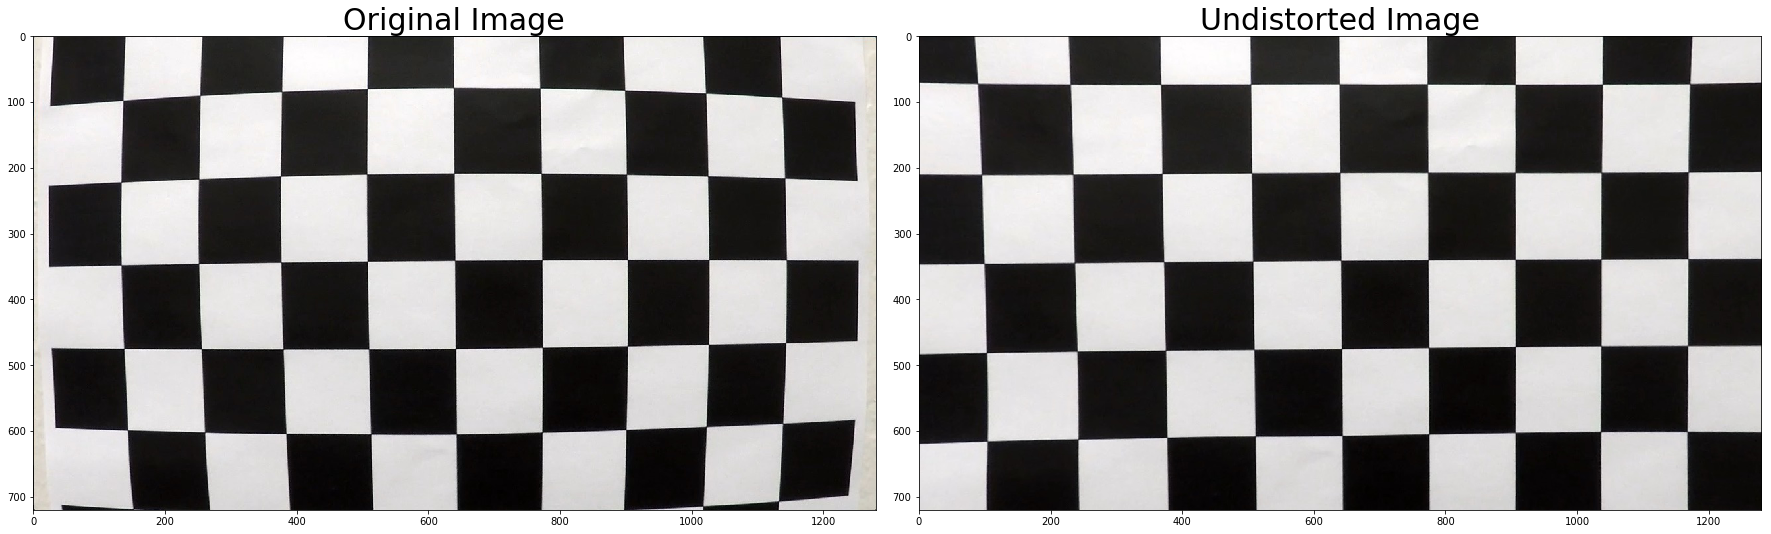

In [5]:
imgpoints,objpoints = find_points(cal_images)
chess_img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(chess_img,objpoints,imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chess_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Undistort Test Image

['./test_images/test6.jpg', './test_images/test5.jpg', './test_images/test4.jpg', './test_images/test1.jpg', './test_images/test3.jpg', './test_images/test2.jpg', './test_images/straight_lines2.jpg', './test_images/straight_lines1.jpg']


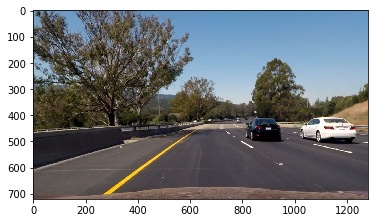

In [6]:
test_images = []
test_fnames = glob.glob('./test_images/*.jpg')
print(test_fnames)
for fname in test_fnames:
    test_img = mpimg.imread(fname)
    undistorted = cal_undistort(test_img,objpoints,imgpoints)
    test_images.append(undistorted)

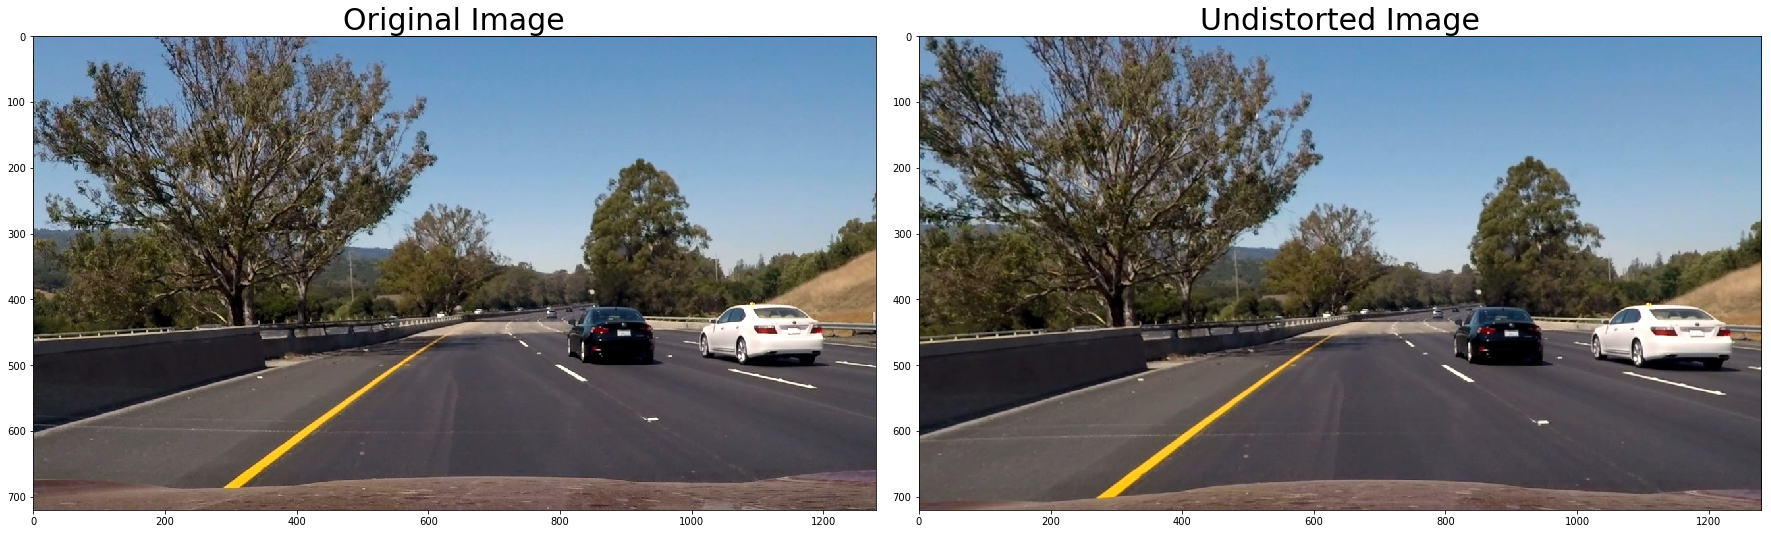

In [7]:
dist_img = mpimg.imread('./test_images/test6.jpg')
undis_img = test_images[0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undis_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Threshold

### 3.1 Gradient Thresholds

In [11]:
def abs_sobel_thresh(gray, sobel_kernel=3, thresh=(0,255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_sobel_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    # calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_sobel_thresh(gray, sobel_kernel=11, thresh=(0, np.pi/2)):
    # calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

### 3.2 Color Thresholds

In [10]:
def h_hls_thresh(hls,thresh=(0,255)):
    # 1) get h channel
    h_channel = hls[:,:,0]
    # 2) apply a threshold to the H channel
    # return a binary image of threshold result
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel >= thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

def l_hls_thresh(hls,thresh=(0,255)):
    # 1) get l channel
    l_channel = hls[:,:,1]
    # 2) apply a threshold to the S channel
    # return a binary image of threshold result
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def s_hls_thresh(hls,thresh=(0,255)):
    # 1) get s channel
    s_channel = hls[:,:,2]
    # 2) apply a threshold to the S channel
    # return a binary image of threshold result
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


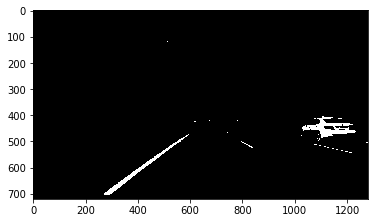

In [9]:
def hlsLSelect(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def labBSelect(img, thresh=(195, 255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 100:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def combined_thresh(img):
    hlsL_binary = hlsLSelect(img)
    labB_binary = labBSelect(img)
    combined_binary = np.zeros_like(hlsL_binary)
    combined_binary[(hlsL_binary == 1) | (labB_binary == 1)] = 1
    return combined_binary
image = test_images[0]
combined_binary = combined_thresh(image)
plt.imshow(combined_binary,cmap='gray')

### 3.3 Combined Threshold

In [8]:
def combined_thresh(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    abs_binary = abs_sobel_thresh(gray, sobel_kernel = 7, thresh =(30,255))
    mag_binary = mag_sobel_thresh(gray, sobel_kernel = 9, thresh =(30,255))
    dir_binary = dir_sobel_thresh(gray, sobel_kernel = 5, thresh =(0.7,1.3))
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_binary = h_hls_thresh(hls,thresh = (10,40))
    l_binary = l_hls_thresh(hls,thresh = (np.amax(hls[:,:,1])/1.75, np.amax(hls[:,:,1])) )
    s_binary = s_hls_thresh(hls,thresh = (160,255))
    combined_output = np.zeros_like(dir_binary)
    combined_output[(abs_binary == 1)|(dir_binary == 1)&(mag_binary == 1) | (h_binary == 1)&(s_binary == 1)] = 1
    return combined_output

### Example: Abs, Mag, Dir, HLS, and Combined Threshold

Text(0.5, 1.0, 'lab_binary')

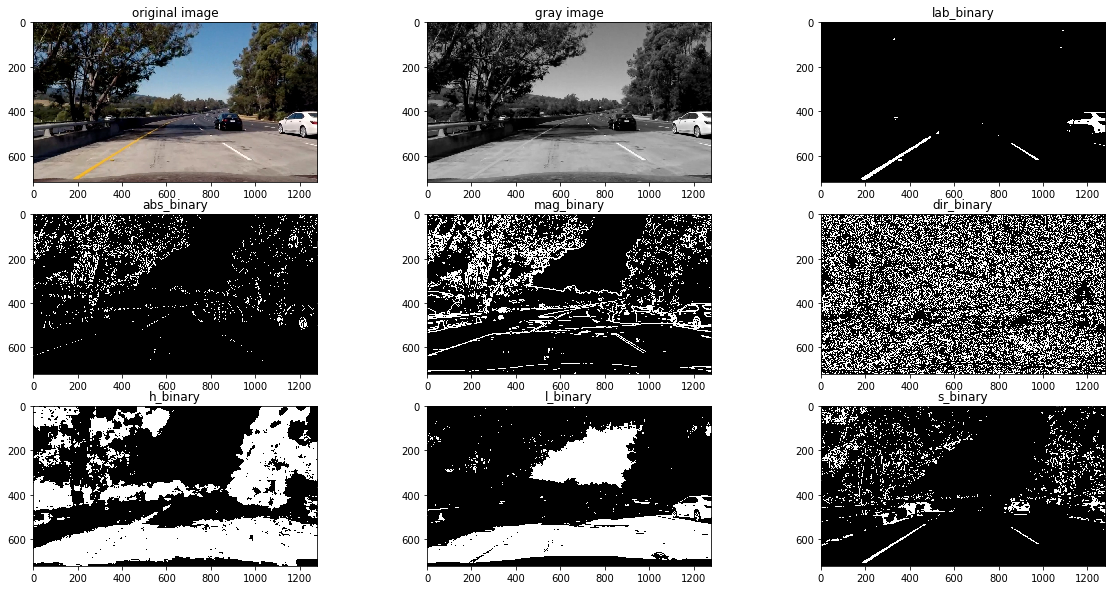

In [12]:
img = test_images[1]
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
abs_binary = abs_sobel_thresh(gray, sobel_kernel = 7, thresh =(30,255))
mag_binary = mag_sobel_thresh(gray, sobel_kernel = 9, thresh =(30,255))
dir_binary = dir_sobel_thresh(gray, sobel_kernel = 5, thresh =(0.7,1.3))

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_binary = h_hls_thresh(hls,thresh = (10,40))
l_binary = l_hls_thresh(hls,thresh = (np.amax(hls[:,:,1])/1.75, np.amax(hls[:,:,1])) )
s_binary = s_hls_thresh(hls,thresh = (160,255))

combined_output = np.zeros_like(dir_binary)
combined_output[(abs_binary == 1)|(dir_binary == 1)&(mag_binary == 1) | (s_binary == 1)] = 1
combined = combined_thresh(img)
fig = plt.figure(figsize=(20,10))

plt.subplot(331)
plt.imshow(img)
plt.title('original image')

plt.subplot(332)
plt.imshow(gray,cmap='gray')
plt.title('gray image')

plt.subplot(334)
plt.imshow(abs_binary,cmap='gray')
plt.title('abs_binary')

plt.subplot(335)
plt.imshow(mag_binary,cmap='gray')
plt.title('mag_binary')

plt.subplot(336)
plt.imshow(dir_binary,cmap='gray')
plt.title('dir_binary')

plt.subplot(337)
plt.imshow(h_binary,cmap='gray')
plt.title('h_binary')

plt.subplot(338)
plt.imshow(l_binary,cmap='gray')
plt.title('l_binary')

plt.subplot(339)
plt.imshow(s_binary,cmap='gray')
plt.title('s_binary')

plt.subplot(333)
plt.imshow(combined,cmap='gray')
plt.title('lab_binary')

### Example: Threshold on Test Images 

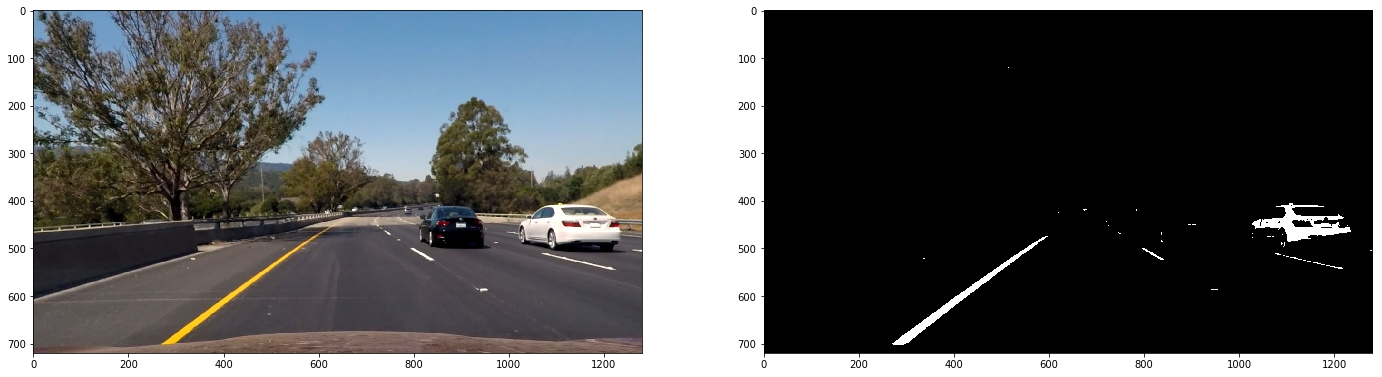

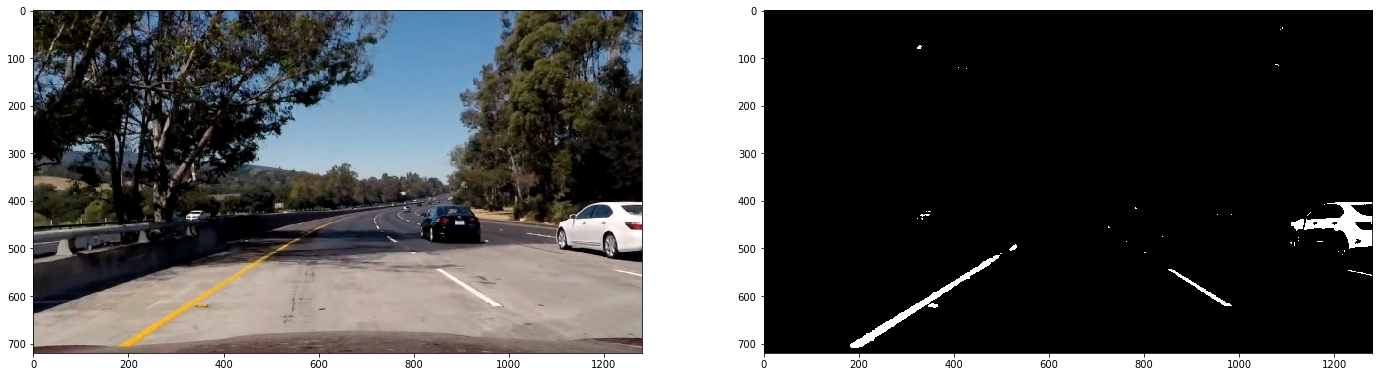

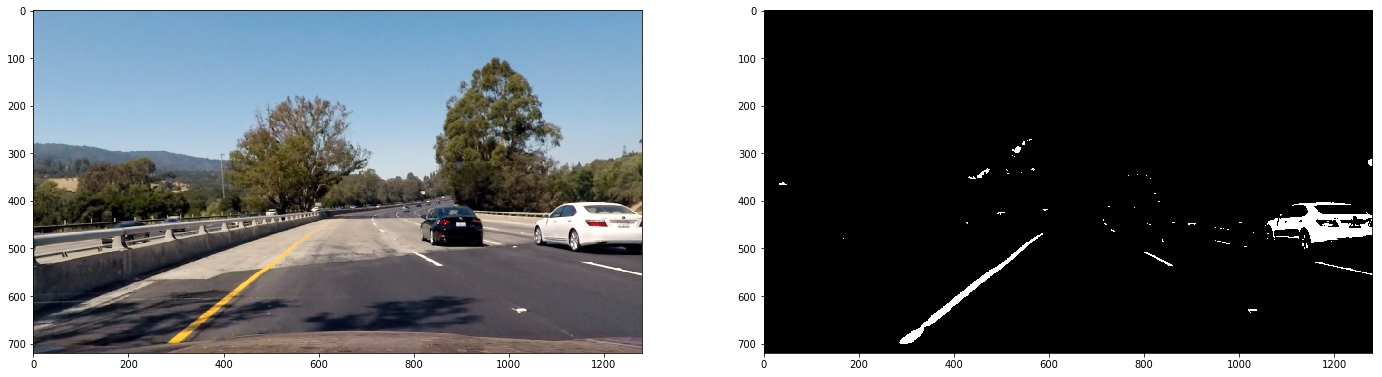

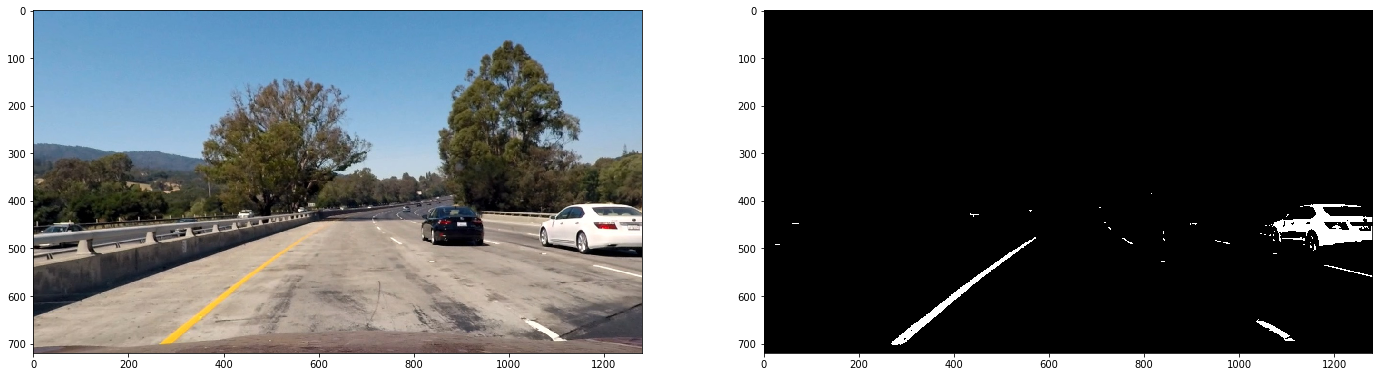

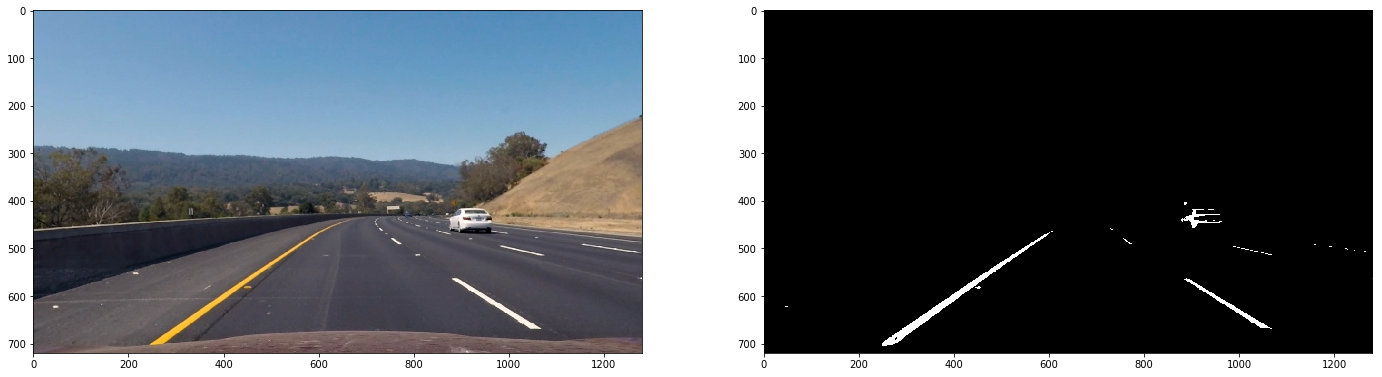

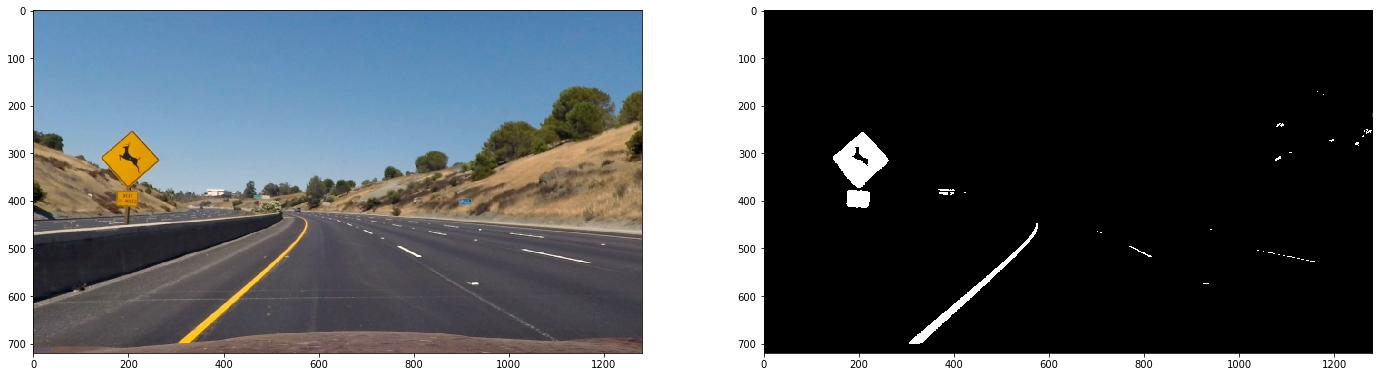

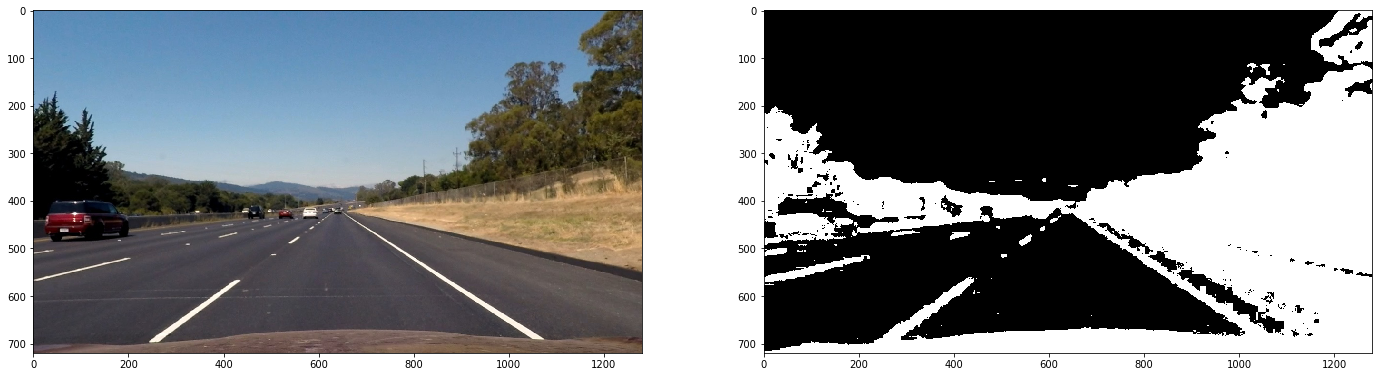

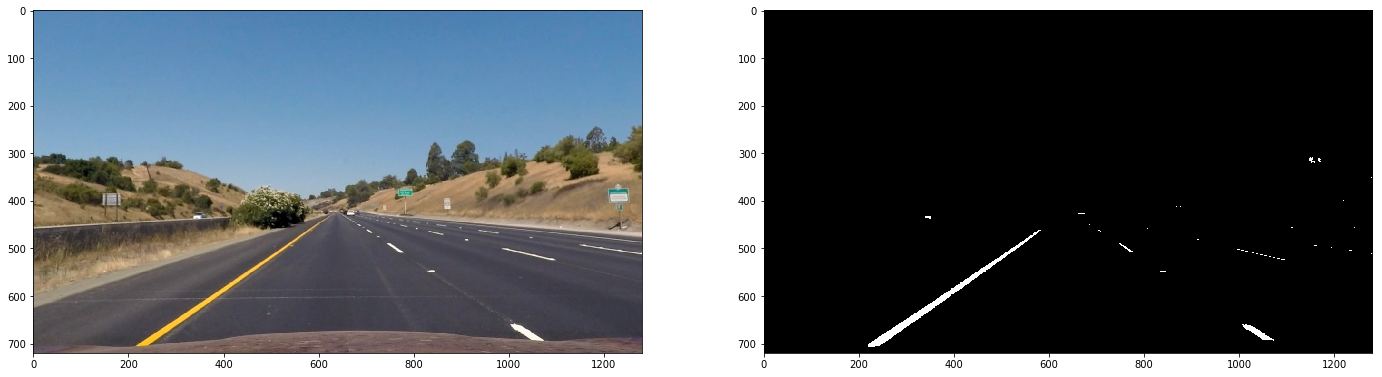

In [12]:
for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax2.imshow(combined_thresh(image), cmap='gray')

## 4. Perspective Transformation

In [14]:
src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def transform_perspective_top(image):
    binary_warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
    return binary_warped

def transform_top_perspective(image):
    binary_warped = cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0]))

### Example: Perspective Transform

Text(0.5, 1.0, 'binary warped')

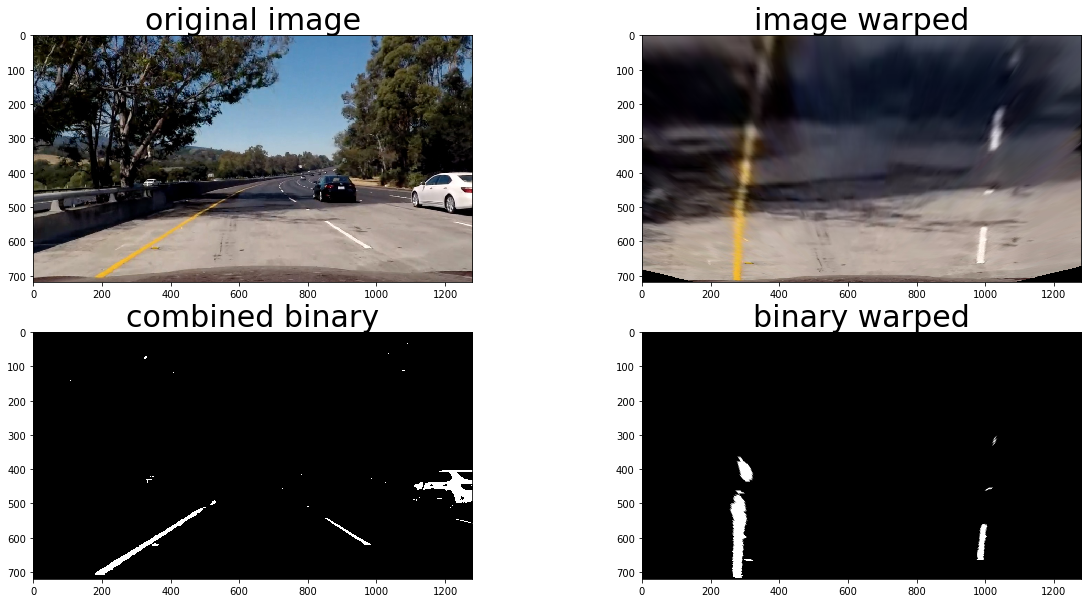

In [15]:
image = test_images[1]
image_warped = transform_perspective_top(image)

combined_binary = combined_thresh(image)
binary_warped = transform_perspective_top(combined_binary)

fig = plt.figure(figsize=(20,10))

plt.subplot(221)
plt.imshow(image)
plt.title('original image', fontsize=30)

plt.subplot(222)
plt.imshow(image_warped)
plt.title('image warped',fontsize=30)

plt.subplot(223)
plt.imshow(combined_binary,cmap='gray')
plt.title('combined binary',fontsize=30)

plt.subplot(224)
plt.imshow(binary_warped,cmap='gray')
plt.title('binary warped',fontsize=30)


# 5. Detect Lane Lines

### 5.1 Define Histogram of Bottom Half

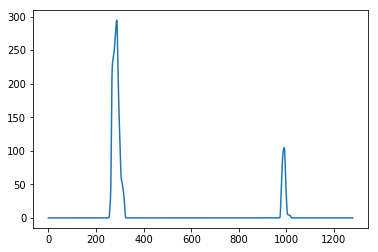

In [16]:
def hist(gray):
    bottom_half = gray[gray.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

image = test_images[1]
combined_binary = combined_thresh(image)
bird_view = transform_perspective_top(combined_binary)
histogram = hist(bird_view)
plt.plot(histogram)

In [17]:
def find_lane_pixels(binary_warped, nwindows=8, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
 

In [18]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
 
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 8
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx_pxl = nonzerox[left_lane_inds]
    lefty_pxl = nonzeroy[left_lane_inds] 
    rightx_pxl= nonzerox[right_lane_inds]
    righty_pxl = nonzeroy[right_lane_inds]

    return leftx_pxl, lefty_pxl, rightx_pxl, righty_pxl, out_img
        
def init_fit_poly(binary_warped):
    # Find our lane pixels first
    leftx_pxl, lefty_pxl, rightx_pxl, righty_pxl, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each
    left_fit_coeff = np.polyfit(lefty_pxl, leftx_pxl, 2)
    right_fit_coeff = np.polyfit(righty_pxl, rightx_pxl, 2)
    
    return left_fit_coeff, right_fit_coeff

def search_around_poly(binary_warped,pre_left_fit,pre_right_fit):
    # Identify the x and y positions of all nonzero pixels in the image
    # Set the width of the windows +/- margin
    margin = 60
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (pre_left_fit[0]*(nonzeroy**2) + pre_left_fit[1]*nonzeroy + 
                    pre_left_fit[2] - margin)) & (nonzerox < (pre_left_fit[0]*(nonzeroy**2) + 
                    pre_left_fit[1]*nonzeroy + pre_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (pre_right_fit[0]*(nonzeroy**2) + pre_right_fit[1]*nonzeroy + 
                    pre_right_fit[2] - margin)) & (nonzerox < (pre_right_fit[0]*(nonzeroy**2) + 
                    pre_right_fit[1]*nonzeroy + pre_right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_coeff = np.polyfit(lefty,leftx,2)
    right_fit_coeff = np.polyfit(righty,rightx,2)
    return left_fit_coeff, right_fit_coeff

def poly_lane(binary_warped, left_fit_coeff, right_fit_coeff):
    ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
    left_fitx = left_fit_coeff[0]*ploty**2 + left_fit_coeff[1]*ploty + left_fit_coeff[2]
    right_fitx = right_fit_coeff[0]*ploty**2 + right_fit_coeff[1]*ploty + right_fit_coeff[2]
    return ploty, left_fitx, right_fitx

### Example: Test on Images  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


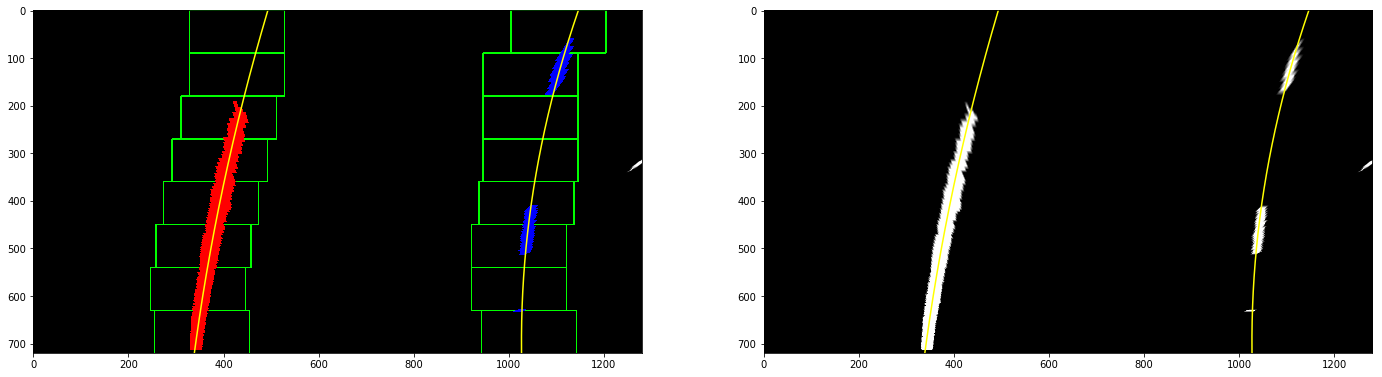

In [19]:
image = test_images[0]
combined_binary = combined_thresh(image)
binary_warped = transform_perspective_top(combined_binary)
left_fit_1, right_fit_1 = init_fit_poly(binary_warped)
left_fit_2, right_fit_2 = search_around_poly(binary_warped, left_fit_1, right_fit_1)

ploty1, left_fitx_1, right_fitx_1= poly_lane(binary_warped, left_fit_1, right_fit_1)
ploty2, left_fitx_2, right_fitx_2= poly_lane(binary_warped, left_fit_2, right_fit_2) 

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
out_img[lefty, leftx] =[255, 0, 0]
out_img[righty, rightx]=[0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(out_img, cmap="gray")
ax1.plot(left_fitx_1, ploty1, color='yellow')
ax1.plot(right_fitx_1, ploty1, color='yellow')

ax2.imshow(binary_warped, cmap="gray")
ax2.plot(left_fitx_2, ploty2, color='yellow')
ax2.plot(right_fitx_2, ploty2, color='yellow')


## 6. Determine the lane curvature

In [28]:
def cal_fit_meter(binary_warped, fit, ym_per_pix=43/720, xm_per_pix=3.7/800):
    ploty = np.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    fit_meter = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix,2)
    
    return fit_meter

def measure_curvature_real(binary_warped, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ploty = np.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
    # Define conversions in x and y from pixels space to meters 
    ym_per_pix = 43/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    
    left_fit_cr = cal_fit_meter(binary_warped, left_fit, ym_per_pix,xm_per_pix)
    right_fit_cr = cal_fit_meter(binary_warped, right_fit, ym_per_pix,xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad


In [84]:
def cal_offset(left_fit, right_fit, y, vehicle_pos_x):
    x_left  = left_fit[0] *y**2 + left_fit[1] *y + left_fit[2]
    x_right = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    return vehicle_pos_x - (x_left + x_right)/2

In [44]:
image = test_images[0]
combined_binary = combined_thresh(image)
binary_warped = transform_perspective_top(combined_binary)
left_fit_1, right_fit_1 = init_fit_poly(binary_warped)
left_fit_2, right_fit_2 = search_around_poly(binary_warped, left_fit_1, right_fit_1)
measure_curvature_real(binary_warped, left_fit_2, right_fit_2)

(2993.945295250042, 1104.1718675847212)

## 7. Draw Lane on Image

In [73]:
def draw_lane_on_image(image, binary_warped, polty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warped, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

### Example: test on images

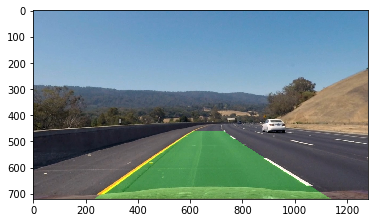

In [79]:
image = test_images[4]
combined_binary = combined_thresh(image)
binary_warped = transform_perspective_top(combined_binary)
left_fit_1, right_fit_1 = init_fit_poly(binary_warped)
left_fit_2, right_fit_2 = search_around_poly(binary_warped, left_fit_1, right_fit_1)
ploty, left_fitx, right_fitx = poly_lane(binary_warped, left_fit_2, right_fit_2) 
result = draw_lane_on_image(image, binary_warped, ploty, left_fitx, right_fitx)
plt.imshow(result)

## Video

In [82]:
class Line():
    def __init__(self):

        self.detected = False  
        self.current_fit = None
        self.radius_of_curvature = None 
        self.line_base_pos = None 


In [97]:
lines_detected=[]
font = cv2.FONT_HERSHEY_SIMPLEX
# define undistortion parameters
imgpoints,objpoints = find_points(cal_images)
# define perspective parameters
src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# define pixel to meter parameters
ym_per_pix=43/720
xm_per_pix=3.7/800
width_in_m = test_images[0].shape[1] * xm_per_pix
height_in_m = test_images[0].shape[0] * ym_per_pix

def draw_detection_images(image):
    image = cal_undistort(image,objpoints,imgpoints)
    refer_line = None
    for i in range(max(0, len(lines_detected)-5),len(lines_detected)):
        line = lines_detected[i]
        if line.detected:
            refer_line = line
            break
    last_fit = None
    
    if refer_line != None:
        last_fit = refer_line.current_fit
    line = Line()
    warped = cv2.warpPerspective(combined_thresh(image), M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    if last_fit == None:
        left_fit, right_fit = init_fit_poly(warped)
    else:
        left_fit, right_fit = search_around_poly(warped, last_fit[0], last_fit[1])
    
    real_left_fit = cal_fit_meter(warped,left_fit)
    real_right_fit = cal_fit_meter(warped,right_fit)
        
    left_radius, right_radius = measure_curvature_real(binary_warped, left_fit, right_fit)
    
    is_radius_reasonable = abs(left_radius) > 10 and abs(right_radius) > 10
    
    radius_of_curvature = (left_radius + right_radius)/2
    line_base_pos = cal_offset(real_left_fit, real_right_fit, height_in_m, width_in_m/2)
    
    if is_radius_reasonable:
        
        line.detected = True
        line.current_fit = (left_fit, right_fit)
        line.radius_of_curvature = radius_of_curvature
        line.line_base_pos = line_base_pos
    else:
        line.detected = False
        if last_fit != None:
            left_fit = last_fit[0]
            right_fit = last_fit[1]
            radius_of_curvature = reference_line.radius_of_curvature
            line_base_pos = reference_line.line_base_pos
            
    lines_detected.append(line)
    
    if line.detected or last_fit != None:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

        left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        cv2.putText(result, 'Curvature: {:8.2f}m, Off_Center: {:4.2f}m'.format(radius_of_curvature, line_base_pos) ,(100,100), font, 1,(255,255,255),2)

        return result
    else:
        return image
    

In [98]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_detected.mp4'
clip1 = VideoFileClip('./project_video.mp4')

lines_detected = []
white_clip = clip1.fl_image(draw_detection_images) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4



 24%|██▍       | 303/1261 [00:57<03:03,  5.23it/s]


 48%|████▊     | 605/1261 [01:57<02:16,  4.80it/s]


 72%|███████▏  | 907/1261 [02:56<01:14,  4.78it/s]


 96%|█████████▌| 1205/1261 [03:55<00:11,  5.07it/s]


100%|█████████▉| 1260/1261 [04:06<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detected.mp4 

CPU times: user 6min 46s, sys: 1min 10s, total: 7min 56s
Wall time: 4min 6s
